In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.layers import LSTM
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [22]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [23]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [24]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('peo_m.csv')

In [25]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [26]:
peo_roll_beta

array([0.9772635 , 0.97014216, 1.00021326, 1.00341387, 0.99066662,
       1.00436244, 0.99490991, 1.02171093, 1.03098369, 1.03367474,
       1.051477  , 1.0441973 , 1.06097197, 1.06000448, 1.03501676,
       1.04392938, 1.05036511, 1.06179624, 1.04459305, 1.05446398,
       1.04846115, 1.0680065 , 1.07123908, 1.07525705, 1.06774364,
       1.08922898, 1.13356561, 1.12231121, 1.11750739, 1.11221958,
       1.11222089, 1.15435166, 1.18812062, 1.26028061, 1.23078474,
       1.43892495, 1.44945814, 1.44257389, 1.49245589, 1.48736234,
       1.48676661, 1.49808716, 1.51245944, 1.49931122, 1.49980717,
       1.5056696 , 1.46281084, 1.46229541, 1.45473297, 1.45703139,
       1.42105982, 1.42173266, 1.42370527, 1.43551197, 1.44929252,
       1.42299995, 1.45985696, 1.45545443, 1.44527129, 1.4413922 ,
       1.44229289, 1.45366658, 1.43358319, 1.40905135, 1.40282212,
       1.47843879, 1.45342916, 1.42107272, 1.42991674, 1.33643484,
       1.37197186, 1.06860085, 1.05577774, 1.06599178, 0.92549

In [27]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})
df_data = df_data.iloc[5:]

In [28]:
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,1.004362,0.990667,1.003414,1.000213,0.970142,0.977263
6,0.994910,1.004362,0.990667,1.003414,1.000213,0.970142
7,1.021711,0.994910,1.004362,0.990667,1.003414,1.000213
8,1.030984,1.021711,0.994910,1.004362,0.990667,1.003414
9,1.033675,1.030984,1.021711,0.994910,1.004362,0.990667
...,...,...,...,...,...,...
200,1.320562,1.322314,1.325707,1.396829,1.325983,1.353047
201,1.368290,1.320562,1.322314,1.325707,1.396829,1.325983
202,1.234932,1.368290,1.320562,1.322314,1.325707,1.396829
203,1.314584,1.234932,1.368290,1.320562,1.322314,1.325707


In [29]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,0.990667,1.003414,1.000213,0.970142,0.977263
6,1.004362,0.990667,1.003414,1.000213,0.970142
7,0.994910,1.004362,0.990667,1.003414,1.000213
8,1.021711,0.994910,1.004362,0.990667,1.003414
9,1.030984,1.021711,0.994910,1.004362,0.990667
...,...,...,...,...,...
200,1.322314,1.325707,1.396829,1.325983,1.353047
201,1.320562,1.322314,1.325707,1.396829,1.325983
202,1.368290,1.320562,1.322314,1.325707,1.396829
203,1.234932,1.368290,1.320562,1.322314,1.325707


In [30]:
y = df_data.target
y

5      1.004362
6      0.994910
7      1.021711
8      1.030984
9      1.033675
         ...   
200    1.320562
201    1.368290
202    1.234932
203    1.314584
204    1.327663
Name: target, Length: 200, dtype: float64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

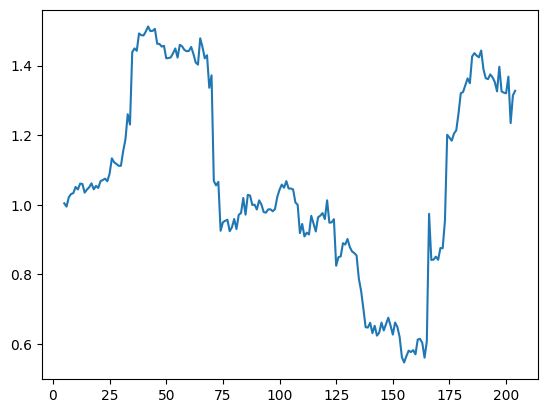

In [32]:
plt.plot(y)

In [33]:
y_test

165    0.606939
166    0.974103
167    0.841483
168    0.842637
169    0.851121
170    0.842051
171    0.875850
172    0.875106
173    0.953912
174    1.201371
175    1.193164
176    1.184191
177    1.204824
178    1.214017
179    1.263135
180    1.320789
181    1.324159
182    1.343358
183    1.363312
184    1.349455
185    1.426222
186    1.435857
187    1.428769
188    1.423958
189    1.443389
190    1.389460
191    1.364066
192    1.361070
193    1.374800
194    1.366442
195    1.353047
196    1.325983
197    1.396829
198    1.325707
199    1.322314
200    1.320562
201    1.368290
202    1.234932
203    1.314584
204    1.327663
Name: target, dtype: float64

Bulding network model

In [81]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())


model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 0s 3ms/step - loss: 1.9788
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 1.5566
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 1.2462
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.9846
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.7655
Epoch 6/200
16/16 [==============================] - 0s 1ms/step - loss: 0.5882
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4512
Epoch 8/200
16/16 [==============================] - 0s 1ms/step - loss: 0.3524
Epoch 9/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2846
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2400
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2064
Epoch 12/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1766
Epoch 13/200
16/16 [=================

In [82]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


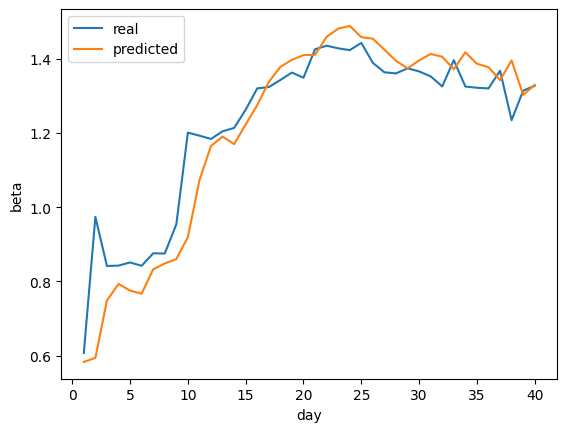

In [83]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_test, label='real')
plt.plot(x,y_pred, label='predicted')
plt.xlabel('day')
plt.ylabel('beta')
plt.legend()
plt.show()

In [84]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [85]:
print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.008936353694627138
MAE: 0.06286203261083241
R^2: 0.8078592024893886


In [86]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [87]:
y_pred = my_model.predict(X_test)

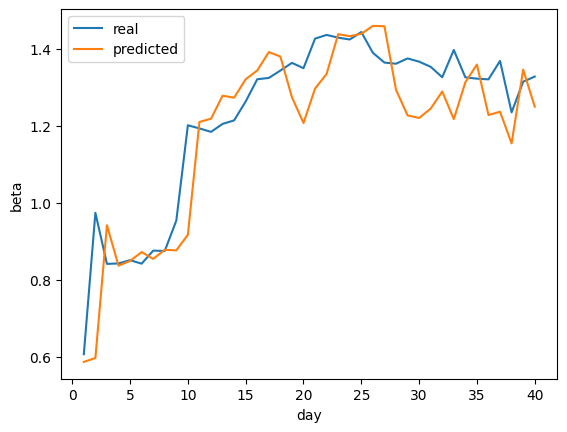

In [88]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_test, label='real')
plt.plot(x,y_pred, label='predicted')
plt.xlabel('day')
plt.ylabel('beta')
plt.legend()
plt.show()

In [89]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [90]:
print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.011604443293256885
MAE: 0.07716865149002528
R^2: 0.7504925313807115


In [99]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 100)            40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 25)                2525      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
160/160 [==============================] - 5s 6ms/step - loss: 0.0320
Epoch 2/3
160/160 [==============================] - 1s 6ms/step - loss: 0.0063
Epoch 3/3
160/160 [==============================] - 1s 6ms/step - loss: 0.0080


In [101]:
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 16ms/step


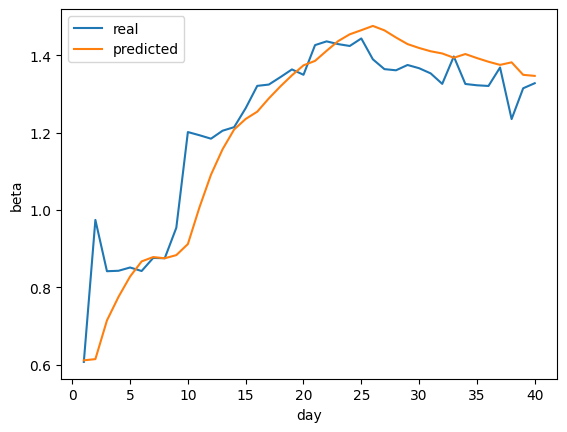

In [102]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_test, label='real')
plt.plot(x,y_pred, label='predicted')
plt.xlabel('day')
plt.ylabel('beta')
plt.legend()
plt.show()

In [103]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [104]:
print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.009389978993916638
MAE: 0.06391028674011454
R^2: 0.798105791897675


In [106]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [107]:
y_pred = model.predict(X_test)

In [ ]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_test, label='real')
plt.plot(x,y_pred, label='predicted')
plt.xlabel('day')
plt.ylabel('beta')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

5/5 [==============================] - 0s 4ms/step


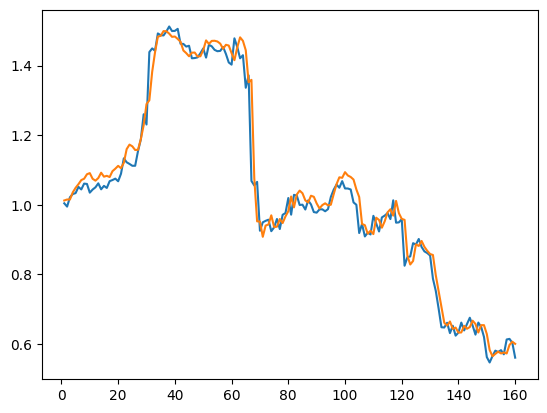

In [43]:
y_pred = model.predict(X_train)
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_train)
plt.plot(x,y_pred)
plt.show()